In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


2025-06-06 04:17:08.000983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 04:17:08.010033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749201428.021966    1036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749201428.024908    1036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749201428.032987    1036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class ImageDataset:
    def __init__(self, data_dir, max_images_per_class=1400):
        self.data_dir = data_dir
        self.max_images_per_class = max_images_per_class
        self.images = []
        self.labels = []
        self.class_names = ['liriomyza', '' 'rust']
        
    def load_data(self):
        """Carga datos con validación mejorada y límite de imágenes"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"⚠️  Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx)
                    class_count += 1
                    total_images += 1
                if class_count >= self.max_images_per_class:
                    print(f"Clase '{label}': Se han cargado el máximo de {self.max_images_per_class} imágenes.")
                    break
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")
        
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None


In [ ]:
print("Clasificador de Plagas")
print("=" * 50)

# 1. Cargar datos
data_dir = 'data_3/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes.")
    exit(1)





Clasificador de Hojas
📊 Clase 'liriomyza': Se han cargado el máximo de 1400 imágenes.
📊 Clase 'liriomyza': 1400 imágenes
📊 Clase 'no_plaga': Se han cargado el máximo de 1400 imágenes.
📊 Clase 'no_plaga': 1400 imágenes
📊 Clase 'rust': Se han cargado el máximo de 1400 imágenes.
📊 Clase 'rust': 1400 imágenes
📈 Total de imágenes cargadas: 4200


In [ ]:
# 2. Preparar datos
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_cat = to_categorical(labels, num_classes=3)

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_cat.shape}")


📊 Datos preparados:
   Imágenes: (4200, 224, 224, 3)
   Etiquetas: (4200, 3)


In [ ]:
# 3. División estratificada
X_train, X_val, y_train, y_val = train_test_split(
        images, labels_cat, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )

print(f"\nDivisión de datos:")
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


🔄 División de datos:
   Entrenamiento: 3360 imágenes
   Validación: 840 imágenes


In [9]:
# Importaciones necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    Multiply, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from keras import Model

In [ ]:
def modelo_base():
    """
    Crea y configura el modelo convolucional para clasificación de hojas.
    """
    inputs = Input(shape=(224, 224, 3))
    
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    attention = Conv2D(32, (1, 1), activation='relu')(x)
    attention = Conv2D(32, (1, 1), activation='sigmoid')(attention)
    x = Multiply()([x, attention])
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
   
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC(),
        ]
    )
    return model

modelo = modelo_base()

I0000 00:00:1749201540.956211    1036 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=5,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        ),
        TensorBoard(
            log_dir='logs',
            histogram_freq=1
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [ ]:
def entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs, batch_size):
    """
    Entrena el modelo con los generadores y callbacks configurados.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    
    return history


In [13]:
history = entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs=10, batch_size=32)

Epoch 1/10


I0000 00:00:1749201547.920731    1395 service.cc:152] XLA service 0x76c9fc009d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749201547.920764    1395 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-06 04:19:08.027528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749201548.590500    1395 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-06 04:19:09.882200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1291', 8 bytes spill stores, 8 bytes spill loads

2025-06-06 04:19:10.384418: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7193 - auc: 0.8688 - loss: 0.7244 - precision: 0.7445 - recall: 0.6870

2025-06-06 04:19:50.509900: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-06 04:19:53.068844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 8 bytes spill stores, 8 bytes spill loads

2025-06-06 04:19:54.279133: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.7199 - auc: 0.8692 - loss: 0.7228 - precision: 0.7450 - recall: 0.6876 - val_accuracy: 0.5690 - val_auc: 0.6835 - val_loss: 1.1126 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.8270 - auc: 0.9513 - loss: 0.4339 - precision: 0.8530 - recall: 0.8073 - val_accuracy: 0.5381 - val_auc: 0.6769 - val_loss: 1.2813 - val_precision: 0.6558 - val_recall: 0.4536 - learning_rate: 1.0000e-04
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.8523 - auc: 0.9612 - loss: 0.3860 - precision: 0.8699 - recall: 0.8315 - val_accuracy: 0.3393 - val_auc: 0.6295 - val_loss: 1.6319 - val_precision: 0.3393 - val_recall: 0.3393 - learning_rate: 1.0000e-04
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.8698 - auc: 0.9698 - loss: 0.3374 - precision: 0.8902 - recall: 0.8525 - val_accuracy: 0.4083 - val_auc: 0.6335 - v

105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.8729 - auc: 0.9730 - loss: 0.3206 - precision: 0.8855 - recall: 0.8590 - val_accuracy: 0.6738 - val_auc: 0.8803 - val_loss: 0.6241 - val_precision: 0.7090 - val_recall: 0.6179 - learning_rate: 5.0000e-05
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9013 - auc: 0.9809 - loss: 0.2639 - precision: 0.9109 - recall: 0.8851

105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.9013 - auc: 0.9809 - loss: 0.2639 - precision: 0.9109 - recall: 0.8851 - val_accuracy: 0.9274 - val_auc: 0.9910 - val_loss: 0.2081 - val_precision: 0.9481 - val_recall: 0.9131 - learning_rate: 5.0000e-05
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9157 - auc: 0.9867 - loss: 0.2218 - precision: 0.9292 - recall: 0.9040

105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9158 - auc: 0.9867 - loss: 0.2218 - precision: 0.9292 - recall: 0.9040 - val_accuracy: 0.9286 - val_auc: 0.9924 - val_loss: 0.1732 - val_precision: 0.9428 - val_recall: 0.9226 - learning_rate: 5.0000e-05
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9189 - auc: 0.9879 - loss: 0.2119 - precision: 0.9311 - recall: 0.9090

105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.9189 - auc: 0.9879 - loss: 0.2121 - precision: 0.9310 - recall: 0.9090 - val_accuracy: 0.9393 - val_auc: 0.9926 - val_loss: 0.1670 - val_precision: 0.9467 - val_recall: 0.9310 - learning_rate: 5.0000e-05
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9136 - auc: 0.9845 - loss: 0.2390 - precision: 0.9236 - recall: 0.9036 - val_accuracy: 0.9262 - val_auc: 0.9881 - val_loss: 0.2030 - val_precision: 0.9358 - val_recall: 0.9190 - learning_rate: 5.0000e-05
Epoch 10/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9217 - auc: 0.9886 - loss: 0.2012 - precision: 0.9327 - recall: 0.9130 - val_accuracy: 0.9393 - val_auc: 0.9897 - val_loss: 0.1835 - val_precision: 0.9464 - val_recall: 0.9250 - learning_rate: 5.0000e-05


In [ ]:
def evaluar_modelo(modelo, X_val, y_val):
    """
    Evalúa el modelo con métricas detalladas.
    """
    y_pred = modelo.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_val, axis=1)

    metrics = {}
    for i in range(3):
        y_pred_i = (y_pred_class == i)
        y_true_i = (y_true_class == i)
        
        metrics[f'clase_{i}'] = {
            'precision': precision_score(y_true_i, y_pred_i),
            'recall': recall_score(y_true_i, y_pred_i),
            'f1': f1_score(y_true_i, y_pred_i),
            'auc': roc_auc_score(y_true_i, y_pred_i)
        }

    metrics['general'] = {
        'accuracy': accuracy_score(y_true_class, y_pred_class),
        'macro_f1': f1_score(y_true_class, y_pred_class, average='macro'),
        'macro_precision': precision_score(y_true_class, y_pred_class, average='macro'),
        'macro_recall': recall_score(y_true_class, y_pred_class, average='macro')
    }
    
    return metrics

metrics = evaluar_modelo(modelo, X_val, y_val)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


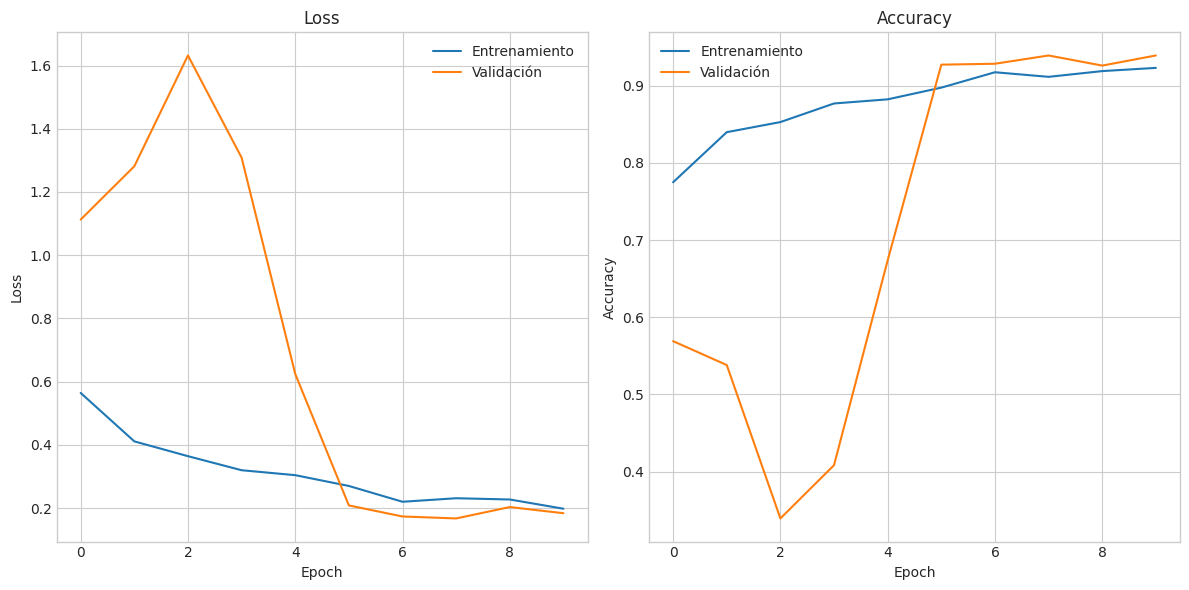

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 6]
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


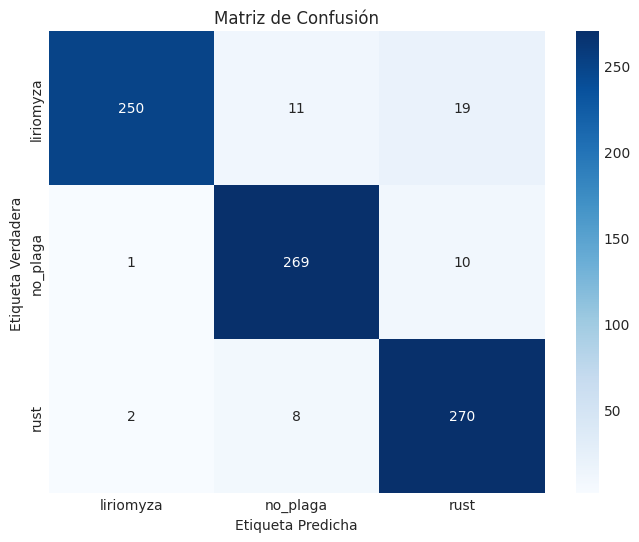

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['liriomyza', 'no_plaga', 'rust']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


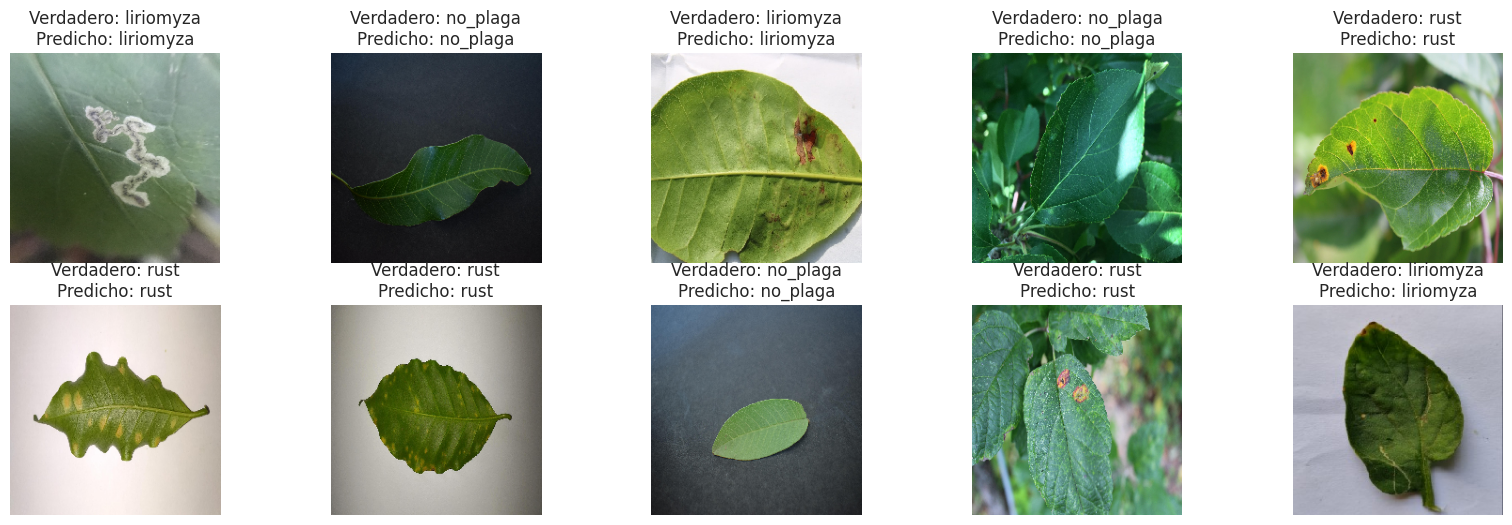

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

indices = random.sample(range(len(X_val)), 10)
class_names = ['liriomyza', 'no_plaga', 'rust']

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    img_input = np.expand_dims(img, axis=0)
    pred_probs = modelo.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [21]:
modelo.save("modelo_plagas_multiclase.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


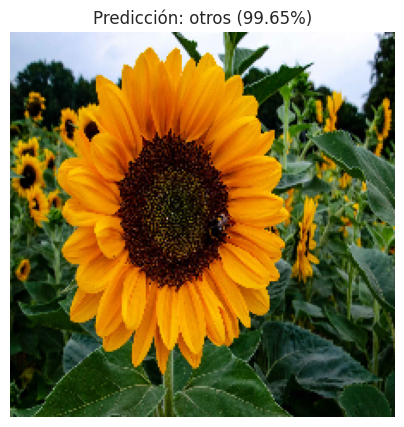

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [1.3728603e-04 9.9650431e-01 3.3583669e-03]
Predicción final: otros con probabilidad 0.9965


In [ ]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

modelo_cargado = load_model('modelo_hojas_multiclase.h5')

img_path = 'tests/sunflower-bee_sonneblume-biene.jpg'

clases = ['hojas', 'otros', 'animales']

img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

prediccion = modelo_cargado.predict(img_array_expanded)

indice_clase = np.argmax(prediccion[0])

etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")